In [817]:
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np

In [818]:
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("crest"))

# Projeto Turing Academy - Promoção de funcionários
- Esse projeto tem como propósito prever, a partir de um dataset com informações de funcionários de uma empresa, se um determinado funcionário deve ou não ser promovido
- Essa predição será feita a partir de modelos de Machine Learning
- Para isso, o *notebook* irá tratar da análise e limpeza dos dados para a conclusão dos melhores modelos para realizar a predição requerida
- A eficiência de cada modelo será avaliada pelo uso de métricas pertinentes a cada caso

## Análise e limpeza dos dados

### Informações básicas do dataset

Com as conclusões feitas a partir desse dataset, os mesmos processos de limpeza serão realizados no dataset de teste

In [819]:
train_employess = pd.read_csv("./train.csv")

- Pequena espiada para se ter uma ideia da estrutura dos dados

In [820]:
train_employess.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1.0,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1.0,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1.0,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2.0,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1.0,45,3.0,2,0,73.0,0


- Análise dos tipos das features para garantir que não há nenhum incoerência e identificar a presença de valores nulos

In [821]:
train_employess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       49962 non-null  float64
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    47350 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 5.4+ MB


In [822]:
train_employess['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [823]:
pd.Series(train_employess['previous_year_rating'].unique())

0    5.0
1    3.0
2    1.0
3    4.0
4    NaN
5    2.0
dtype: float64

In [824]:
pd.Series(train_employess['is_promoted'].unique())

0    0
1    1
dtype: int64

- Quanto aos tipos das variáveis:
  - `is_promoted` deveria ser uma categoria, pois representa 1 para promovidos e 0 para não promovidos
  - `awards_won?` também deveria ser uma categoria, pois representa 1 para funcionários que ganharam prêmios e 0 para aqueles que não ganharam
- Das 54808 entradas, há algumas colunas com dados nulos: `education`, `no_of_trainings`, `previous_year_rating`, `avg_training_score`    

#### Procurando dados duplicados

In [825]:
duplicated = train_employess.duplicated().any()
print(f'{"Há" if duplicated else "Não há"} dados duplicados no dataset')

Não há dados duplicados no dataset


#### Analisando valores numéricos

In [826]:
train_employess.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.0,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
no_of_trainings,49962.0,1.256475,0.612734,1.0,1.00,1.0,1.0,10.0
age,54808.0,273.521530,5422.563711,-32.0,29.00,33.0,39.0,123456.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.00,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.00,5.0,7.0,37.0
awards_won?,54808.0,0.023172,0.150450,0.0,0.00,0.0,0.0,1.0
avg_training_score,47350.0,63.514213,13.492071,39.0,51.00,60.0,77.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.00,0.0,0.0,1.0


É possível perceber que a média das idades está muito alta, sendo os valores máximos e mínimos extremamente fora da realidade

In [827]:
train_employess.describe(include=["object"]).T

,count,unique,top,freq
department,54808,10,Sales & Marketing,16840
region,54808,35,region_2,12343
education,52399,3,Bachelor's,36669
gender,54808,5,m,35010
recruitment_channel,54808,3,other,30446


### Limpeza dos dados

- Idade

In [828]:
train_employess["age"].describe()

count     54808.000000
mean        273.521530
std        5422.563711
min         -32.000000
25%          29.000000
50%          33.000000
75%          39.000000
max      123456.000000
Name: age, dtype: float64

Como já foi mencionado, é possível perceber que há idades com valores muito altos assim como há idades com valores muito menores que 0, o que evidencia *outliers* incoerentes. Os gráficos abaixo ajudam a visualizar o efeito desses *outliers*

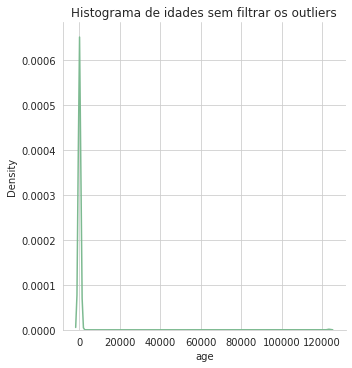

In [829]:
sns.displot(data=train_employess['age'], kind='kde')
plt.title("Histograma de idades sem filtrar os outliers")
plt.show()

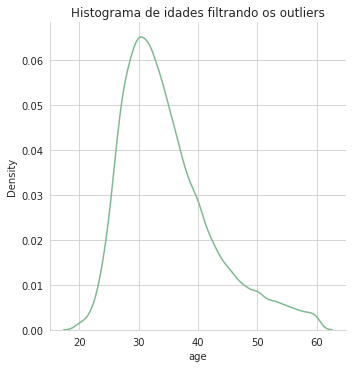

In [830]:
sns.displot(train_employess[(train_employess["age"] < 100) & (train_employess["age"] > 0)]["age"], kind='kde')
plt.title("Histograma de idades filtrando os outliers")
plt.show()

Portanto é possível perceber que as idades que **não** configuram outliers estão entre 0 e 100

In [831]:
age_less_than_0 = train_employess[train_employess["age"] < 0]["age"]

In [832]:
age_less_than_0.value_counts()

-32    3
Name: age, dtype: int64

In [833]:
age_more_than_100 = train_employess[train_employess["age"] > 100]["age"]

In [834]:
age_more_than_100.value_counts()

123456    106
Name: age, dtype: int64

Como há apenas um valor de idade menor que 0 no dataset, é possível substituí-lo pelo seu módulo, que é coerente com a distribuição de idades nos dados

In [835]:
train_employess["age"].replace(-32, 32, inplace=True)

Jás as idades maiores que 100 anos têm mais representar e não é possível inferir nenhum valor diretamente a partir delas. Para evitar a remoção de dados do dataset, substitui-se essas idades pela mediana, que é uma idade coerente com aquela esperada para o mercado de trabalho, além de coincidir com a maior concentração de idades no histograma

In [836]:
train_employess["age"].replace(123456, train_employess["age"].median(), inplace=True)

Analisando a nova distribuição de idades

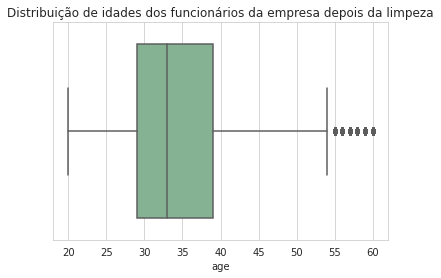

In [837]:
sns.boxplot(data=train_employess, x="age").set(title="Distribuição de idades dos funcionários da empresa depois da limpeza")
plt.show()

- Gênero

É possível perceber que há uma quantidade de gêneros maior que 2, o que pode levar a concluir que o dataset está levando em conta não só a classicação de gênero "masculino" ou "feminino"

In [838]:
genders = pd.Series(train_employess["gender"].unique())
train_employess["gender"].value_counts()

m                                   35010
f                                   15739
MALE                                 3262
fEMALE                                573
eu sou homem hetero homossexual!      224
Name: gender, dtype: int64

Analisando as entradas na feature gênero, é possível perceber que a maior quantidade de gêneros registrado é uma incoerência nos dados, sendo apenas umas das entradas um gênero que diferente de masculino e feminino, o que não é algo que irá influenciar na análise

Como há muitos valores que diferentes de "m" e "f" na coluna gênero, é preciso manter a coerência ao substituir os dados, não sendo uma escolha interessantes substituir todos eles por uma escolha arbitrária entre "m" e "f".



In [839]:
mapping = {genders[2]: 'm', genders[3]: 'f', genders[4]: 'm'}
train_employess.replace(mapping, inplace=True)

In [840]:
pd.Series(train_employess["gender"].unique())

0    f
1    m
dtype: object

- Lidando com valores nulos

Primeiro, é preciso identificar quais colunas têm valores nulos (e quantos são esses valores) a fim de tratá-los

In [841]:
def inspect_null_columns(df):
  rows,_ = df.shape
  colums_with_null_values = df.columns[df.isna().any()]
  series = df[colums_with_null_values].isna().sum()
  return series

Porcentagem de valores nulos para cada coluna

In [842]:
inspect_null_columns(train_employess) / train_employess.shape[0] * 100

education                4.395344
no_of_trainings          8.841775
previous_year_rating     7.524449
avg_training_score      13.607503
dtype: float64

Porcentagem total de dados nulos

In [843]:
f"{(inspect_null_columns(train_employess) / train_employess.shape[0] * 100).sum()} % de dados nulos"

'34.36907020872866 % de dados nulos'

Como as porcentagens são relativamente altas, não e possivel retirar dados com informações faltantes do dataframe

Analisando os dados faltantes nas colunas de `avg_training_score` e `no_of_trainings`, percebe-se que as linhas que estão com dados faltantes. No entanto, nem todas as colunas com `avg_training_rate` nulo têm `no_of_trainings` nulo, o que causaria uma incosistência ao zerar todos os `avg_training_score` faltantes. 

In [844]:
# Porcentagem de registros com avg_training_socore nulo, mas com no_of_trainings não nulo
filter1 = train_employess['avg_training_score'].isna()
filter2 = ~train_employess['no_of_trainings'].isna()
train_employess[(filter1) & (filter2)].shape[0] / train_employess.shape[0]

0.04765727631002773

Como apenas aproximadamente 4% dos dados satisfazem essas condições, é mais conveniente excluir essas linhas do que tentar prever um valor coerente para o `avg_training_score`

In [845]:
train_employess = train_employess[~((filter1) & (filter2))]

Por serem variáveis numéricas que indicam um progresso, ou seja, quanto mais treinamento (`no_of_trainings`), melhor avaliação (`previous_year_rating`) e maior média nos treinamentos (`avg_training_score`), melhor deve ser o desempenso do candidato, valores nulos para essas colunas podem ser substituídos por 0, o que indica que o funcionário não conta com nenhuma dessas métricas ainda.

In [846]:
numeric_columns_with_null_values = ['no_of_trainings', 'previous_year_rating', 'avg_training_score']
new_values = [0 for i in range(len(numeric_columns_with_null_values))]
mapping = dict(zip(numeric_columns_with_null_values, new_values))
train_employess = train_employess.fillna(mapping)

Como `education` e uma coluna de dados categóricos, é preciso fazer uma análise mais cuidados para a limpeza dos dados

In [847]:
educations = pd.Series(train_employess['education'].unique())
educations

0    Master's & above
1          Bachelor's
2                 NaN
3     Below Secondary
dtype: object

É possivel perceber que o mais baixo nível de escolaridade e `Below Secondary`. Portanto, as pessoas com educação nula, podem se encaixar nesse grau de escolaridade

In [848]:
train_employess.fillna({'education': educations[3]}, inplace=True)

In [849]:
inspect_null_columns(train_employess)

Series([], dtype: float64)

*   Outros valores categóricos

Agora irão ser analisadas as coerencias dos outros dados categóricos, que podem conter inconsistências que não são identificadas tão claramente pelo número de categorias, como no gênero

In [850]:
categorical = pd.Series(train_employess.select_dtypes(include=['object']).columns)
categorical

0             department
1                 region
2              education
3                 gender
4    recruitment_channel
dtype: object

**Departamento**

In [851]:
departments = train_employess[categorical[0]].unique()
departments

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Finance', 'Procurement', 'HR', 'Legal',
       'quem trouxe quenga'], dtype=object)

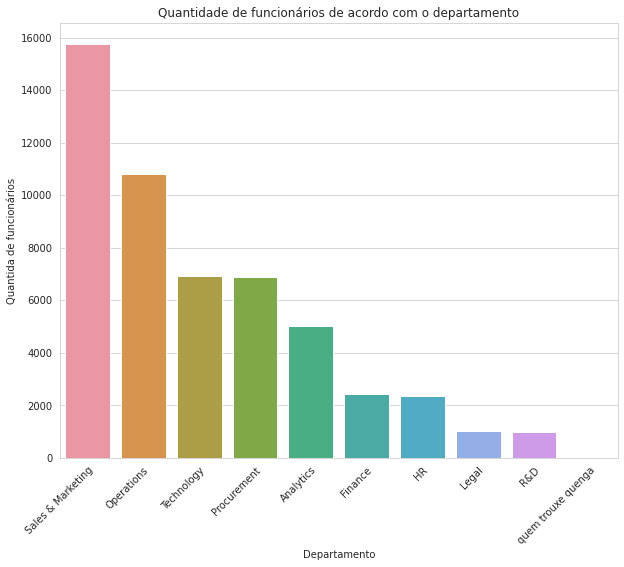

In [852]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_employess, x=categorical[0], order=train_employess['department'].value_counts().index)
plt.title('Quantidade de funcionários de acordo com o departamento')
plt.xlabel('Departamento')
plt.ylabel('Quantida de funcionários')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [853]:
# Porcentagem de pessoas do departamento quem trouxe quenga
train_employess[train_employess['department'] == departments[-1]].size / train_employess.shape[0]

0.005977469537895624

Por ser um valor que tem poucos registros dentro do dataset, é possivel removê-los

In [854]:
train_employess = train_employess[train_employess['department'] != departments[-1]]

**Região**

In [855]:
regions = train_employess[categorical[1]].unique()
regions

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_11', 'region_5',
       'region_17', 'region_13', 'region_16', 'region_25', 'region_10',
       'region_27', 'region_30', 'region_21', 'region_8', 'region_14',
       'region_32', 'region_6', 'region_12', 'region_33', 'region_24',
       'region_3', 'region_9', 'region_28', 'region_18',
       'casa da lu na suecia'], dtype=object)

A região `casa da lu na suécia` foge do padrão

In [856]:
train_employess[train_employess['region'] == regions[-1]].shape[0] / train_employess.shape[0]

7.666947788085564e-05

Por ser uma porcentagem muito pequena, é possivel remover essas linhas

In [857]:
train_employess = train_employess[train_employess['region'] != regions[-1]]
regions = train_employess['region'].unique()
regions

array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_11', 'region_5',
       'region_17', 'region_13', 'region_16', 'region_25', 'region_10',
       'region_27', 'region_30', 'region_21', 'region_8', 'region_14',
       'region_32', 'region_6', 'region_12', 'region_33', 'region_24',
       'region_3', 'region_9', 'region_28', 'region_18'], dtype=object)

**Canal de recrutamento**

In [858]:
recruitment_channel = train_employess[categorical[4]].unique()
recruitment_channel

array(['sourcing', 'other', 'referred'], dtype=object)

* Ajustando os tipos de variáveis

In [859]:
train_employess['is_promoted'] = train_employess['is_promoted'].astype('category')

In [860]:
train_employess['awards_won?'] = train_employess['awards_won?'].astype('category')

**Assim, conclui-se a limpeza dos dados**

## Análise dos dados antes da predição

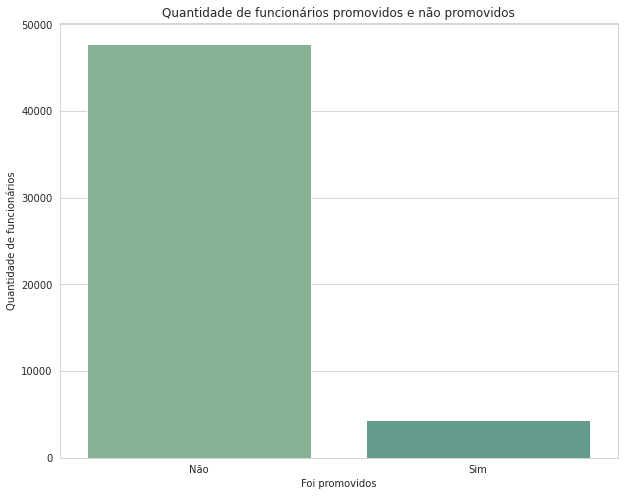

In [861]:
plt.figure(figsize=(10,8))
sns.countplot(data=train_employess, x='is_promoted')
plt.title('Quantidade de funcionários promovidos e não promovidos')
plt.ylabel('Quantidade de funcionários')
plt.xlabel('Foi promovidos')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

Percebe-se que não muito mais funcionários que não foram promovidos em relação aqueles que foram promovidos

## Buscando correlação entre os dados

* Em uma primeira tentativa, para o melhor entendimento dos dados, busca-se uma correlação direta entre variáveis numericas a partir de um heatmap

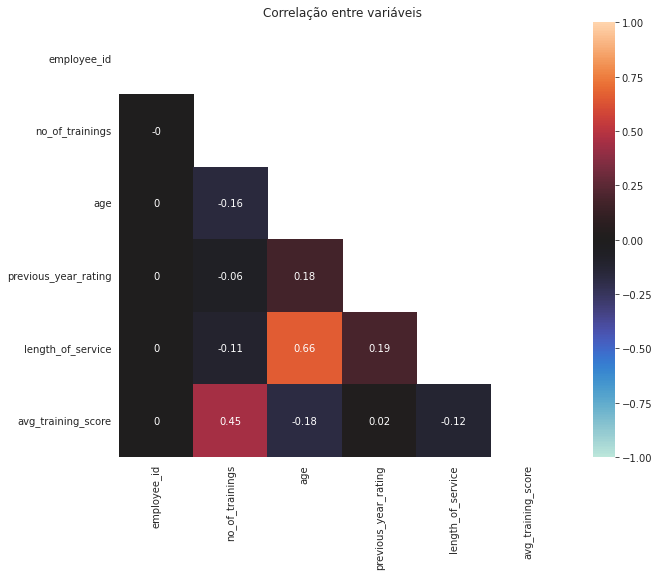

In [862]:
plt.figure(figsize=(10, 8))
corr = train_employess.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax=1, vmin=-1, center=0, annot=np.round(corr.values, 2), mask=mask)
plt.title("Correlação entre variáveis")
plt.show()

Percebe-se que as correlações mais fortes estão entre os campos `age` e `leangth_of_service` e entre os campos `no_of_trainings` e `avg_training_score`
Agora essas relações serão mais exploradas a fim de serrem entendidas

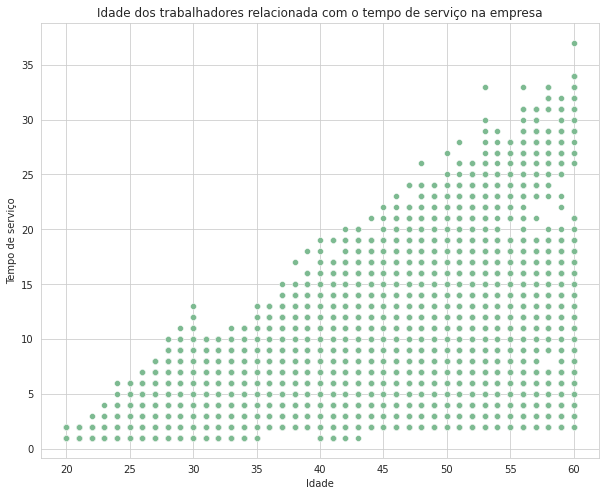

In [863]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train_employess, x='age', y='length_of_service')
plt.title("Idade dos trabalhadores relacionada com o tempo de serviço na empresa")
plt.ylabel("Tempo de serviço")
plt.xlabel("Idade")
plt.show()

A partir do gráfico, percebe-se que as pessoas com mais tempo de serviço tendem a ter mais idade, o que é esperado

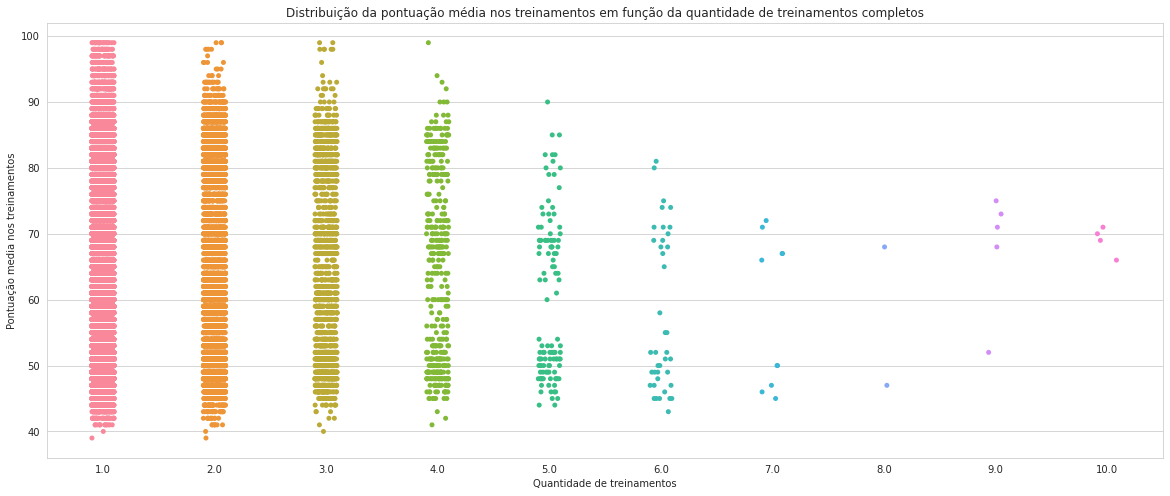

In [864]:
plt.figure(figsize=(20, 8))
sns.stripplot(data=train_employess[train_employess['no_of_trainings'] > 0], x='no_of_trainings', y='avg_training_score')
plt.title("Distribuição da pontuação média nos treinamentos em função da quantidade de treinamentos completos")
plt.xlabel("Quantidade de treinamentos")
plt.ylabel("Pontuação media nos treinamentos")
plt.show()

A partir do gráfico, percebe-se que quanto maior o número de treinamentos, menor é a concentração de notas mais baixas. No entanto, os poucos dados para números de treinamenos mais altos não permiter conclusões tão evidentes

* Em seguida, para melhor entender a predição a ser feita, é preciso buscar coreelações entre as `features` e a coluna `target`, ou seja, `is_promoted`. Começando pelas variáveis numéricas, temos:

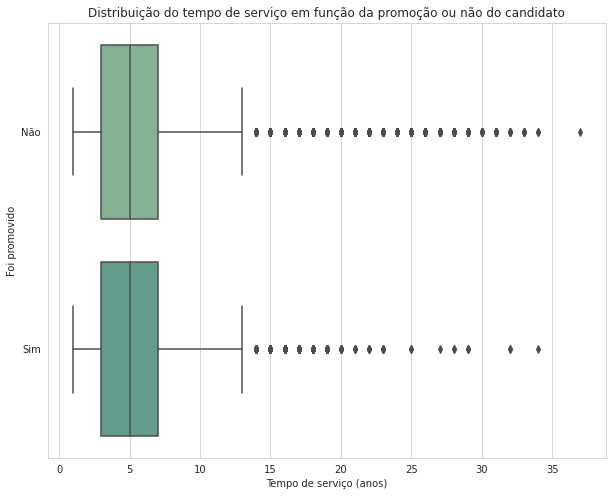

In [865]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=train_employess, x='length_of_service', y='is_promoted')
plt.title("Distribuição do tempo de serviço em função da promoção ou não do candidato")
plt.xlabel("Tempo de serviço (anos)")
plt.ylabel("Foi promovido")
plt.yticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

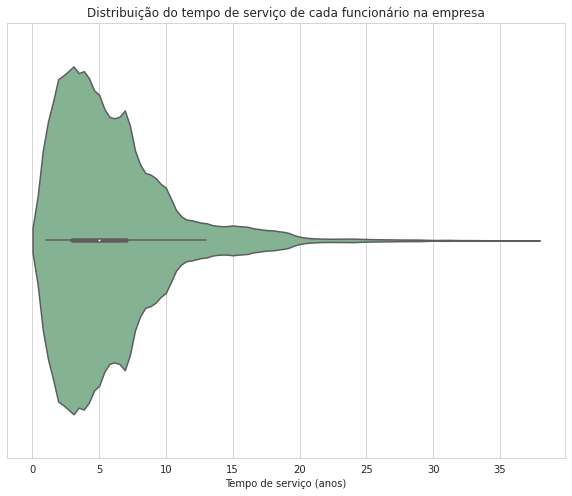

In [866]:
plt.figure(figsize=(10, 8))
sns.violinplot(data=train_employess, x='length_of_service')
plt.title("Distribuição do tempo de serviço de cada funcionário na empresa")
plt.xlabel("Tempo de serviço (anos)")
plt.show()

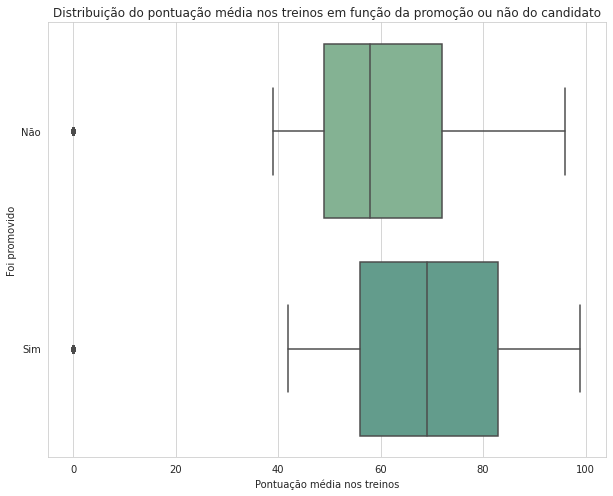

In [867]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=train_employess, x='avg_training_score', y='is_promoted')
plt.title("Distribuição do pontuação média nos treinos em função da promoção ou não do candidato")
plt.xlabel("Pontuação média nos treinos")
plt.ylabel("Foi promovido")
plt.yticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

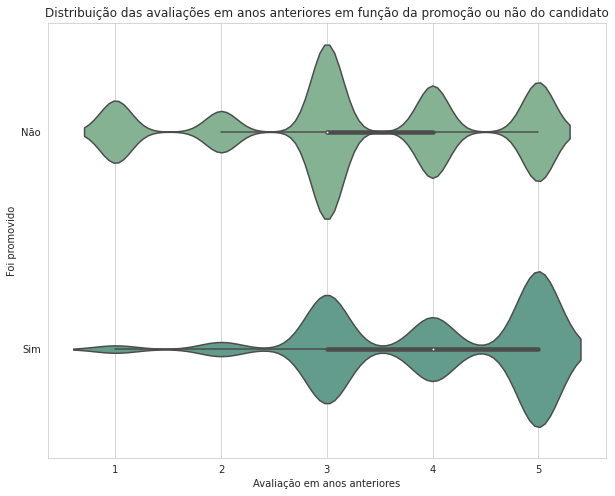

In [868]:
plt.figure(figsize=(10, 8))
sns.violinplot(data=train_employess[train_employess['previous_year_rating'] > 0], x='previous_year_rating', y='is_promoted')
plt.title("Distribuição das avaliações em anos anteriores em função da promoção ou não do candidato")
plt.xlabel("Avaliação em anos anteriores")
plt.ylabel("Foi promovido")
plt.yticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

Dessa análise, é possível concluir que:
1. O **tempo de serviço e a idade não influenciam da promoção dos funcionários**. Verificando essa relação mais detalhadamento com um  `violin plot`, percebe-se que isso ocorre principalmente pelo fato de a empresa ter a maioria dos seus funcionarios com pouco tempo de serviço na empresa e com idades parecidas.
2. A **pontuação nos treinamentos (`avg_training_score`) e a avaliação em anos anteriores (`previous_year_rating`) têm influência**: há valores maiores para funcionários que são promovidos. Há uma maior concetração de notas menores e médias nos funcionários não promovidos, enquanto a concentração de notas maiores é maior para os funcionários promovidos

---



* Agora, irá ser inspecionada a influência das variáveis categoricas na `target feature`

In [869]:
def get_relative_values(column):
  """
    Função responsável por devolver a porcentagem de funcionários promovidos e
  não promovidos em relação a uma determinada feature
  """
  promoted = train_employess['is_promoted'] == 1

  employees_per_column =  train_employess[column].value_counts()
  promoted_employees_per_column = train_employess[promoted][column].value_counts()

  values = promoted_employees_per_column / employees_per_column
  sorted_values = values.sort_values()
  return sorted_values

**Nivel de escolaridade**

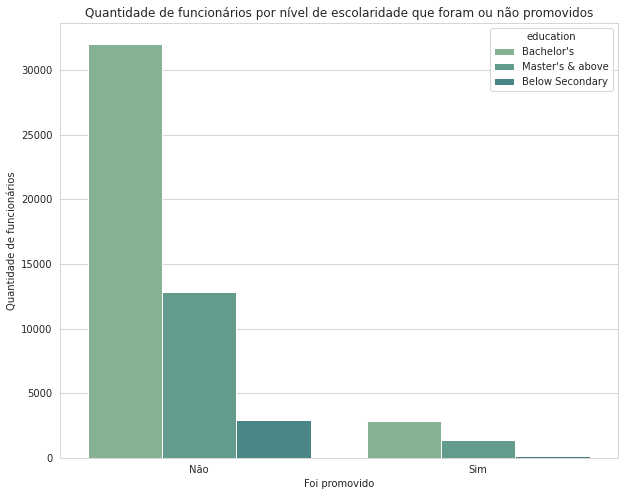

In [870]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_employess, x='is_promoted', hue='education', hue_order=train_employess['education'].value_counts().index)
plt.title('Quantidade de funcionários por nível de escolaridade que foram ou não promovidos')
plt.xlabel('Foi promovido')
plt.ylabel('Quantidade de funcionários')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

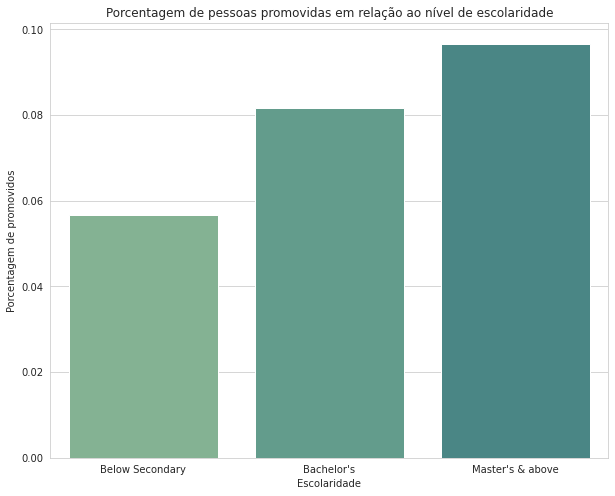

In [871]:
plt.figure(figsize=(10, 8))
sorted_values = get_relative_values('education')

sns.barplot(x=sorted_values.keys(), y=sorted_values)
plt.title('Porcentagem de pessoas promovidas em relação ao nível de escolaridade')
plt.xlabel('Escolaridade')
plt.ylabel('Porcentagem de promovidos')
plt.show()

In [872]:
train_employess[train_employess['is_promoted'] == 1]['education'].value_counts()

Bachelor's          2845
Master's & above    1373
Below Secondary      175
Name: education, dtype: int64

Pessoas com um maior nível de escolaridade têm maior tendência a serem promovidas. Das pessoas com `Master's & above`, cerca de 9.8% foram promovidas, o que é aproximadamente 3% a menos da porcentagem de promoção entre as pessoas `Below Secondary`

**Gênero**

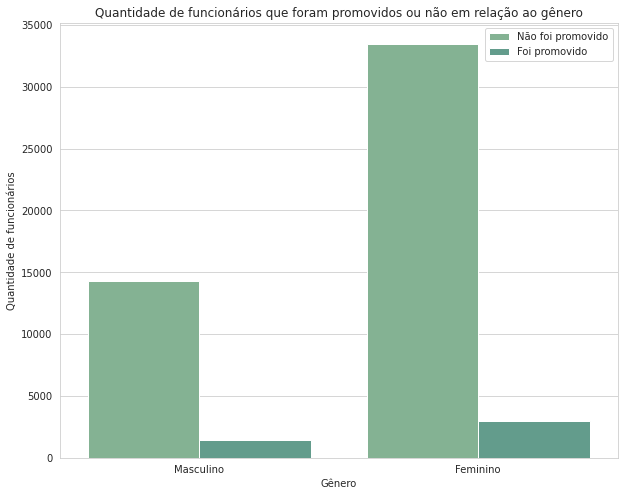

In [873]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_employess, x='gender', hue='is_promoted')
plt.title('Quantidade de funcionários que foram promovidos ou não em relação ao gênero')
plt.xlabel('Gênero')
plt.ylabel('Quantidade de funcionários')
plt.legend(['Não foi promovido', 'Foi promovido'])
plt.xticks(ticks=[0, 1], labels=['Masculino', 'Feminino'])
plt.show()

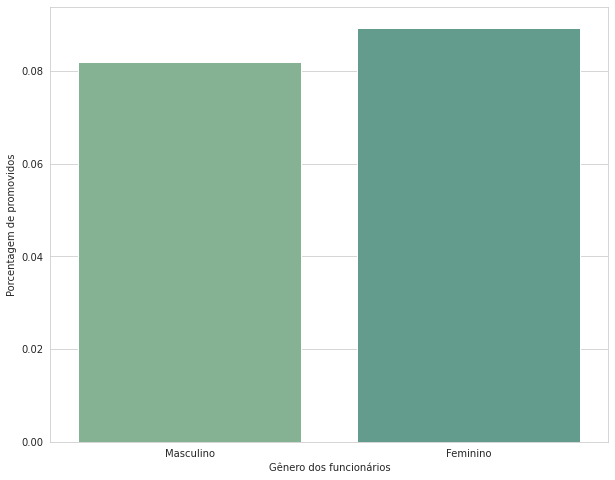

In [874]:
plt.figure(figsize=(10, 8))
sorted_values = get_relative_values('gender')
sns.barplot(x=sorted_values.keys(), y=sorted_values)
plt.xlabel('Gênero dos funcionários')
plt.ylabel('Porcentagem de promovidos')
plt.xticks(ticks=[0, 1], labels=['Masculino', 'Feminino'])
plt.show()

A influência do gênero para a promoção é pequena. Apesar de haverem mais promoções para pessoas do gênero feminino, a diferença relativa entre pessoas promovidas de cada gênero é menor que 1%, podendo ser desconsiderada.

**Awards Won**

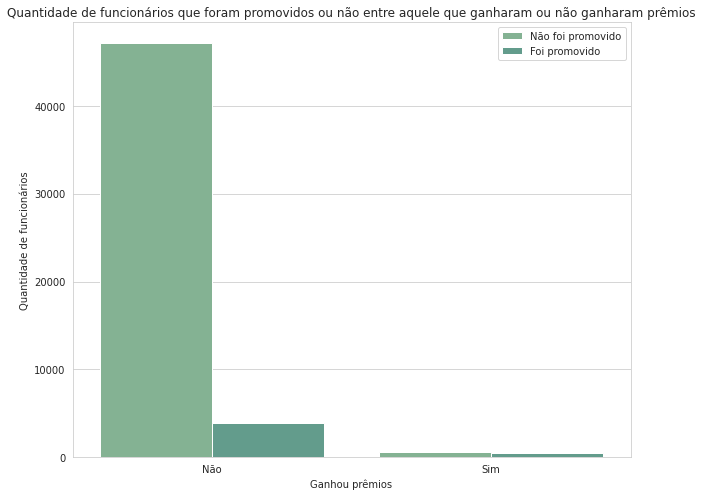

In [875]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_employess, hue='is_promoted', x='awards_won?')
plt.title('Quantidade de funcionários que foram promovidos ou não entre aquele que ganharam ou não ganharam prêmios')
plt.xlabel('Ganhou prêmios')
plt.ylabel('Quantidade de funcionários')
plt.legend(['Não foi promovido', 'Foi promovido'])
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

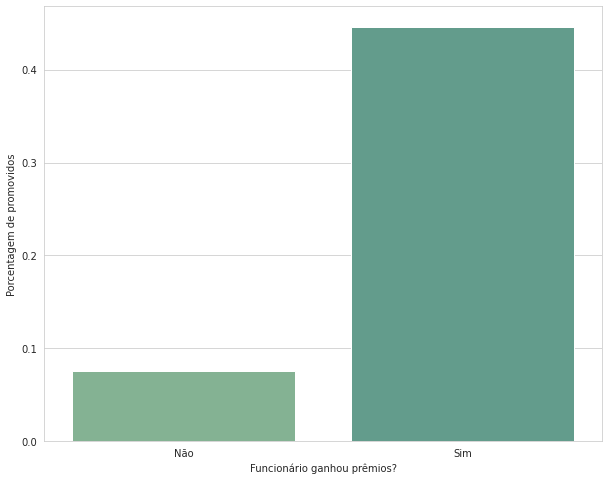

In [876]:
plt.figure(figsize=(10, 8))
sorted_values = get_relative_values('awards_won?')

sns.barplot(x=sorted_values.keys().astype('string'), y=sorted_values)
plt.xlabel('Funcionário ganhou prêmios?')
plt.ylabel('Porcentagem de promovidos')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

Já para as pessoas que ganharam ou não prêmio, há uma grande influência. A quantidade relativa de pessoas que ganharam prêmios dentre os promovidos é mais de 30% maior em relação aqueles que não ganharam nenhum prêmio.

**Region**

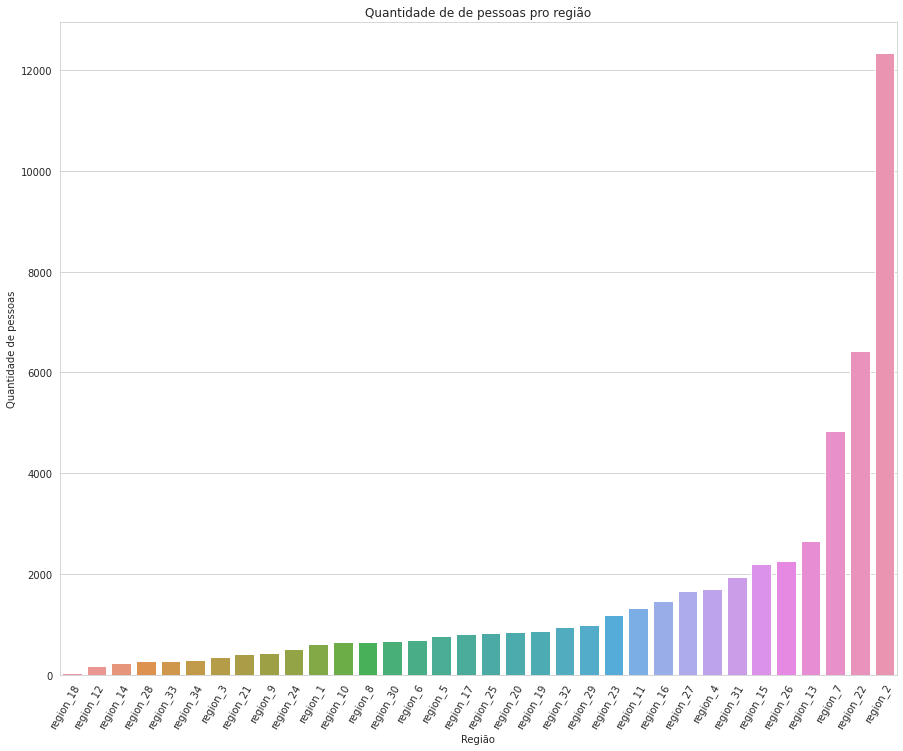

In [877]:
plt.figure(figsize=(15, 12))
sns.countplot(data=train_employess, x='region', order=train_employess['region'].value_counts(ascending=True).index)
plt.xticks(rotation=60, ha='right', rotation_mode='anchor')
plt.title('Quantidade de de pessoas pro região')
plt.xlabel('Região')
plt.ylabel('Quantidade de pessoas')
plt.show()

Nesse gráfico, é possivel perceber que há pessoas de regiões distintas no dataset, sendo a sitribuição dentro deas regiões extremamente descontínua

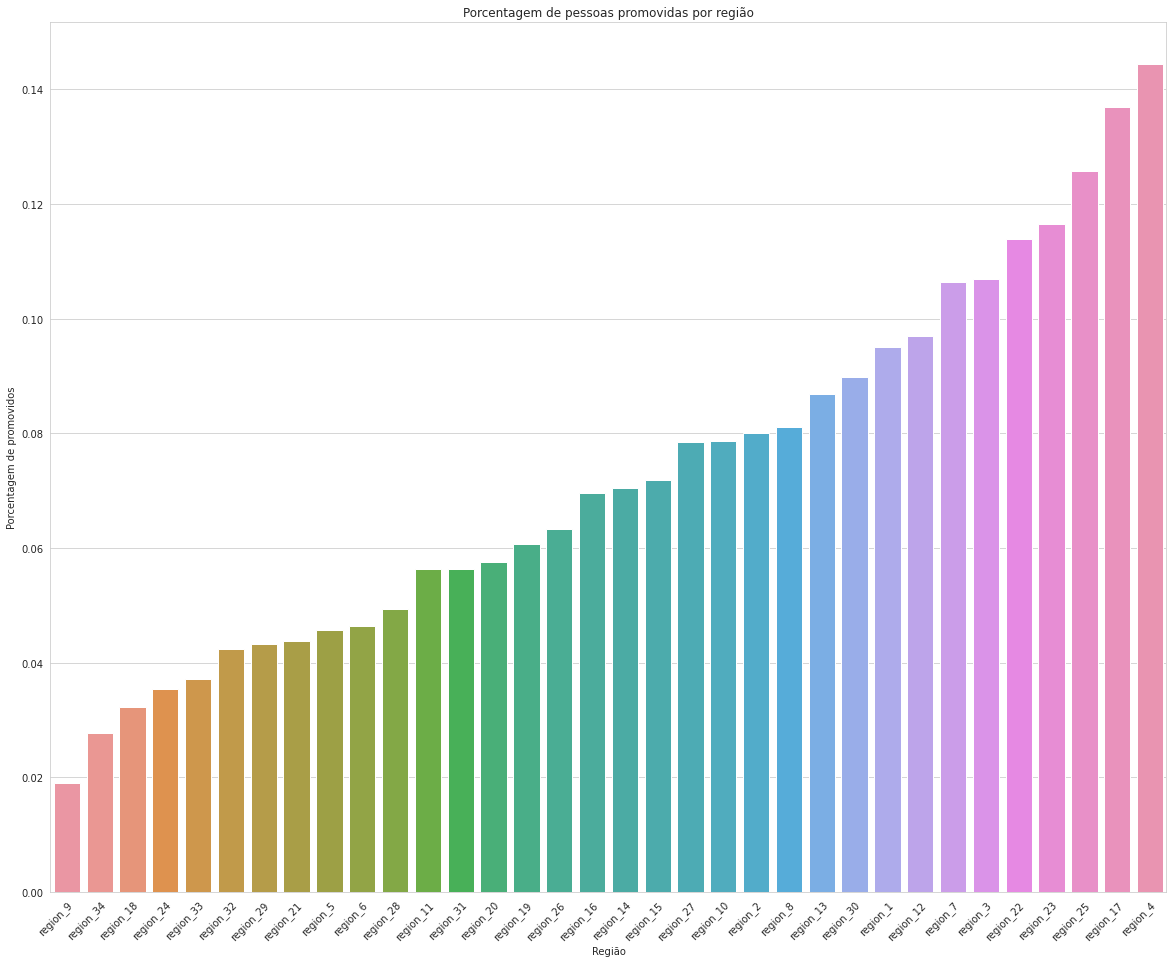

In [878]:
plt.figure(figsize=(20, 16))

sorted_values = get_relative_values('region')

sns.barplot(x=sorted_values.keys(), y=sorted_values)

plt.title('Porcentagem de pessoas promovidas por região')
plt.xlabel('Região')
plt.ylabel('Porcentagem de promovidos')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

Analisando valores relativos, há diferenças de até aproximadamente 15% entre pessoas promovidas dentro de uma determinada região. Esse caso extremo ocorre entre as regiões `region_9` e `region_4`.

**Departamento**

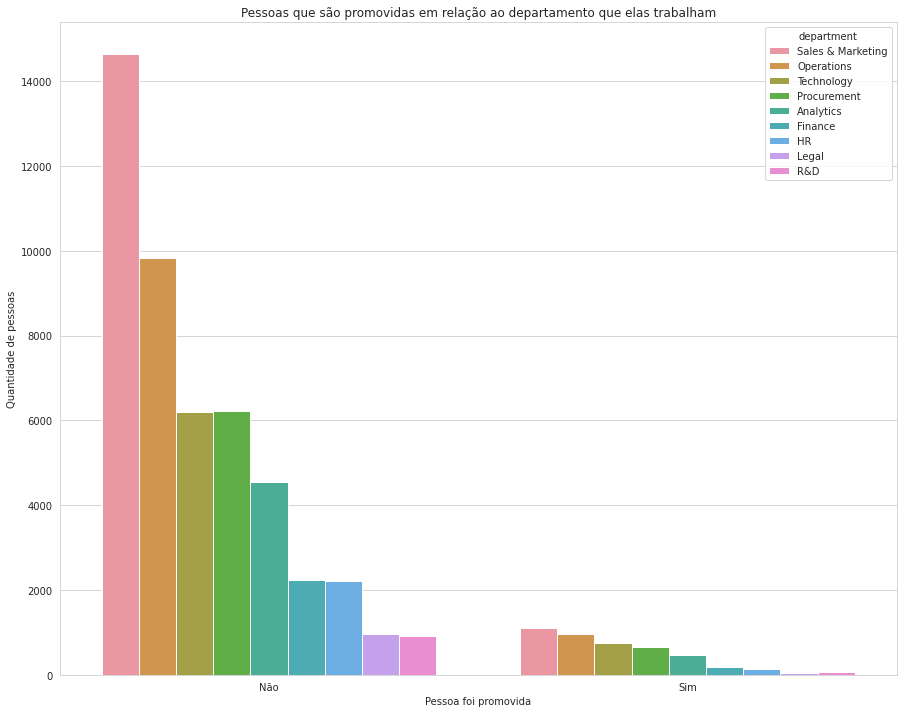

In [879]:
plt.figure(figsize=(15, 12))
sns.countplot(data=train_employess, x='is_promoted', hue='department', hue_order=train_employess['department'].value_counts().index)
plt.title('Pessoas que são promovidas em relação ao departamento que elas trabalham')
plt.xlabel('Pessoa foi promovida')
plt.ylabel('Quantidade de pessoas')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

Pelo gráfico, é possível antecipar algumas diferenças relativas entre promovidos de diferentes departamentos. Por exemplo, apesar de haver uma quantidade muito maior de pessoas em `Sales & Marketing` do que em `Operations`, a quantidade de promovidos desses dois departamentos não é tão distante, o que indica uma maior quantidade relativa de promovidos no departamento de `Operations`.

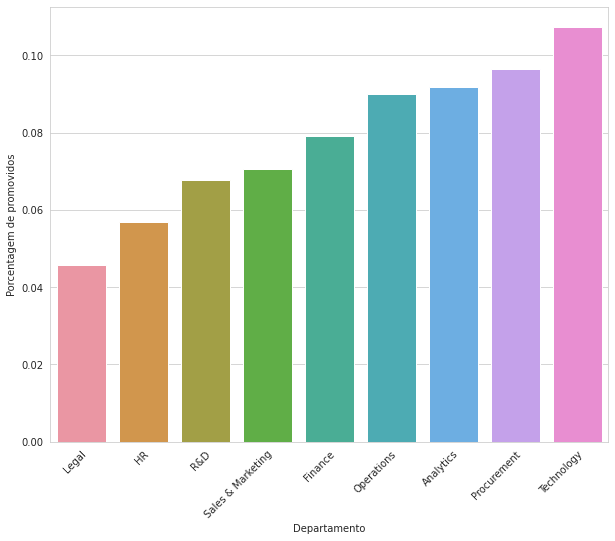

In [880]:
plt.figure(figsize=(10, 8))
sorted_values = get_relative_values('department')

sns.barplot(x=sorted_values.keys(), y=sorted_values)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Departamento')
plt.ylabel('Porcentagem de promovidos')
plt.show()

A hipótese inicial é comprovada a partir do gráfico acima, sendo que o departamento com maior quantidade relativa de promoções e o departamento de `Technology`, com aproximadamente 5% a mais do que `Legal`, o departamento com menor quantidade relativa de pessoas promovidas

**Recruitment Channel**

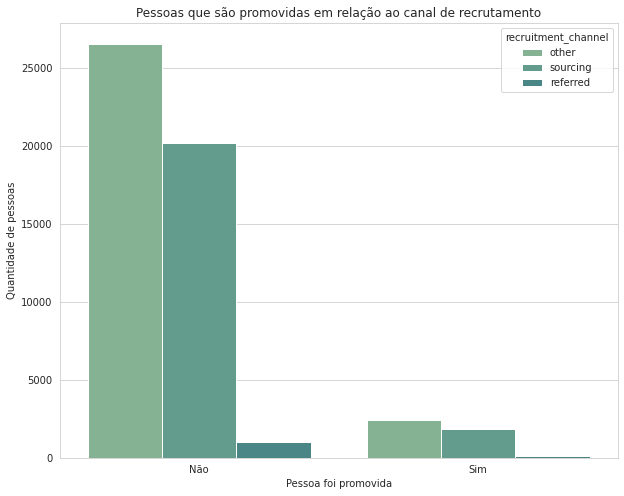

In [881]:
plt.figure(figsize=(10, 8))
sns.countplot(data=train_employess, x='is_promoted', hue='recruitment_channel', hue_order=train_employess['recruitment_channel'].value_counts().index)
plt.title('Pessoas que são promovidas em relação ao canal de recrutamento')
plt.xlabel('Pessoa foi promovida')
plt.ylabel('Quantidade de pessoas')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

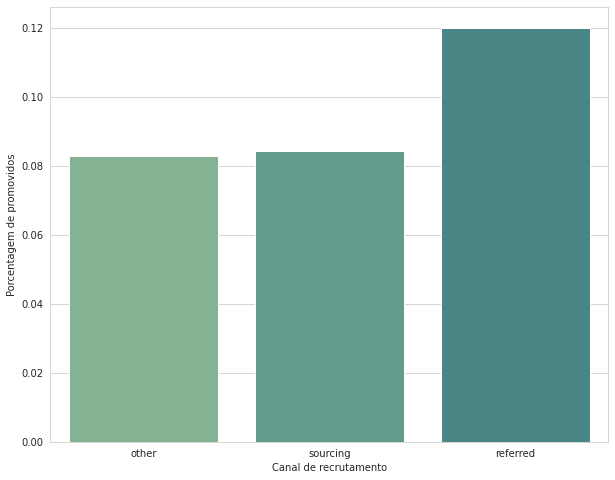

In [882]:
plt.figure(figsize=(10, 8))
sorted_values = get_relative_values('recruitment_channel')

sns.barplot(x=sorted_values.keys(), y=sorted_values)
plt.xlabel('Canal de recrutamento')
plt.ylabel('Porcentagem de promovidos')
plt.show()

É possível perceber que a quantidade de pessoas promovidas é aproximadamente 4% maior para aqueles que foram contratados por referência, o que pode indicar uma influêcia

A partir dessa análise é possível concluir que as features categóricas com maior influência no `taget` são
1. `awards_won?`
2. `region`
3. `education`
4. `department`

## Predição

### Limpeza dos dados de teste

* Antes de começar, é preciso limpar a base de teste, seguindo o mesmo padrão da base de treino

In [883]:
test_employees = pd.read_csv("test.csv")

In [884]:
test_employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       21417 non-null  float64
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  awards_won?           23490 non-null  int64  
 11  avg_training_score    23490 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 2.2+ MB


In [885]:
test_employees.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,23490.0,39041.399149,22640.809201,3.0,19370.25,38963.5,58690.0,78295.0
no_of_trainings,21417.0,1.257132,0.604853,1.0,1.00,1.0,1.0,9.0
age,23490.0,34.782929,7.679492,20.0,29.00,33.0,39.0,60.0
previous_year_rating,21678.0,3.339146,1.263294,1.0,3.00,3.0,4.0,5.0
length_of_service,23490.0,5.810387,4.207917,1.0,3.00,5.0,7.0,34.0
awards_won?,23490.0,0.022776,0.149191,0.0,0.00,0.0,0.0,1.0
avg_training_score,23490.0,63.263133,13.411750,39.0,51.00,60.0,76.0,99.0


In [886]:
test_employees.describe(include=['object']).T

,count,unique,top,freq
department,23490,10,Sales & Marketing,7315
region,23490,35,region_2,5299
education,22456,3,Bachelor's,15578
gender,23490,4,m,15222
recruitment_channel,23490,3,other,13078


In [887]:
categorical = pd.Series(test_employees.select_dtypes(include=['object']).columns)
categorical

0             department
1                 region
2              education
3                 gender
4    recruitment_channel
dtype: object

* **Department**

In [888]:
departments = pd.Series(test_employees['department'].unique())
departments

0            Technology
1                    HR
2     Sales & Marketing
3           Procurement
4               Finance
5             Analytics
6            Operations
7                 Legal
8                   R&D
9    quem trouxe quenga
dtype: object

In [889]:
invalid_department_filter = test_employees['department'] == departments[9]
test_employees[invalid_department_filter].shape[0] / test_employees.shape[0]

0.00029799914857386124

In [890]:
test_employees.drop(test_employees[invalid_department_filter].index, inplace=True)

* **Region**

In [891]:
regions = pd.Series(test_employees['region'].unique())
regions

0                region_26
1                 region_4
2                region_13
3                 region_2
4                region_29
5                 region_7
6                region_22
7                region_16
8                region_17
9                region_24
10               region_11
11               region_27
12                region_9
13               region_20
14               region_34
15               region_23
16                region_8
17               region_14
18               region_31
19               region_19
20                region_5
21               region_28
22               region_15
23                region_3
24               region_25
25               region_12
26               region_21
27               region_30
28               region_10
29               region_33
30               region_32
31                region_6
32                region_1
33               region_18
34    casa da lu na suecia
dtype: object

In [892]:
invalid_region_filter = test_employees['region'] == regions[34]
test_employees[invalid_region_filter].shape[0] / test_employees.shape[0]

8.516799386790444e-05

In [893]:
test_employees.drop(test_employees[invalid_region_filter].index, inplace=True)

* **Gender**

In [894]:
genders = pd.Series(test_employees['gender'].unique())
genders

0         m
1         f
2      MALE
3    fEMALE
dtype: object

In [895]:
test_employees.loc[:, 'gender'] = test_employees.loc[:, 'gender'].replace({genders[2]: 'm', genders[3]: 'f'})

* **Education**

In [896]:
educations = pd.Series(test_employees['education'].unique())
educations

0          Bachelor's
1    Master's & above
2                 NaN
3     Below Secondary
dtype: object

* **Recruitment channel**

In [897]:
channels = pd.Series(test_employees['recruitment_channel'].unique())
channels

0    sourcing
1       other
2    referred
dtype: object

* **Valores nulos**

In [898]:
inspect_null_columns(test_employees) / test_employees.shape[0]

education               0.044036
no_of_trainings         0.088242
previous_year_rating    0.077169
dtype: float64

In [899]:
test_employees.fillna({'previous_year_rating': 0, 'no_of_trainings': 0, 'education': educations[3]}, inplace=True)

In [900]:
inspect_null_columns(test_employees)

Series([], dtype: float64)

In [901]:
test_employees['awards_won?'] = test_employees['awards_won?'].astype('category')

### Modelos

In [902]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

**Setup do dataset para predição**



In [903]:
train_employess = train_employess.set_index('employee_id')
test_employees = test_employees.set_index('employee_id')

In [904]:
# Removendo a coluna target, mas deixando todas as variáveis
employees_train = train_employess.drop('is_promoted', axis=1)
# Criando dummy variables
employees_train_dummy = pd.get_dummies(employees_train, drop_first=True)

# Removendo a coluna target e as variáveis não importantes para a predição
employees_train2 = employees_train.drop(['gender', 'age', 'length_of_service'], axis=1)
employees_train_dummy2 = pd.get_dummies(employees_train2, drop_first=True)

X = employees_train_dummy.values
y = train_employess['is_promoted'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [905]:
kf = KFold(n_splits=5, shuffle=True)

#### **Regressão logística**

Em primeira tentativa, é possível tentar usar _Linear Regression_

In [906]:
logreg = LogisticRegression(solver='liblinear')

In [907]:
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(logreg, X, y, cv=kf)

array([0.9195898 , 0.92006901, 0.9186314 , 0.92332023, 0.9178568 ])

Dada as altas acurácias na validação cruzada, é possível fazer hyperparameter tuning para o modelo.

Os parâmetros levados em conta serão
- Penalty: para evitar _overfitting_ ou _undefitting_ do modelo, que pode ocorrer principalmente devido ao desbalança na quantidade de classes.
- C: para coordenar a regularização, evitando resultados muito extremos para penalização
- O salver `saga` é escolhido por suportar os dois tipos de penalidade e por ser ideal para datasets maiores

In [908]:
logreg = LogisticRegression(solver='liblinear')

alpha_space = np.linspace(0.1, 1, num=20)
penalty_space = ['l1', 'l2',]

logreg_cv = GridSearchCV(logreg, {'C': alpha_space, 'penalty': penalty_space}, cv=5, n_jobs=-1)

logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                         'penalty': ['l1', 'l2']})

Identificando a melhor acurácia e _penalty_ encontrados

In [909]:
best_C = logreg_cv.best_params_['C']
best_penalty = logreg_cv.best_params_['penalty']
print(f'Acuracy equals to {logreg_cv.best_score_} for C={best_C} and penalty={best_penalty}')

Acuracy equals to 0.9202562856207421 for C=0.7157894736842105 and penalty=l2


**Analisando as métricas do modelos com os dados de test**

* Acurracy

In [910]:
logreg_cv.score(X_test, y_test)

0.918791131557089

Uma alta acurácia pode indicar um bom comportamento do modelo, mas não é única métrica necessária para validação

* _Confusion Matrix_ e _Classification Report_

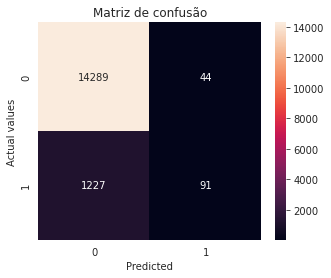

In [911]:
y_pred = logreg_cv.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.title('Matriz de confusão')
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual values')
plt.show()

In [912]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     14333
           1       0.67      0.07      0.13      1318

    accuracy                           0.92     15651
   macro avg       0.80      0.53      0.54     15651
weighted avg       0.90      0.92      0.89     15651



O modelo indica uma grande quantidade de _true positives_ e, entre os dados previstos erroneamente, os _false positives_ são mais abundates, ou seja, o _recall é maior que a precisão_. 


No entanto, o _recall_ para a identificar funcionários promovidos é extremamente baixo, havendo uma grande quantidade de _false negatives_, ou seja, pessoas que o modelo classifica como promovidas, mas na verdade não são. Isso é efeito do grande desbalanceamento dos dados: há muito mais pessoas não promovidas

* ROC Curve

In [913]:
y_pred_probs = logreg_cv.predict_proba(X_test)[:, 1]

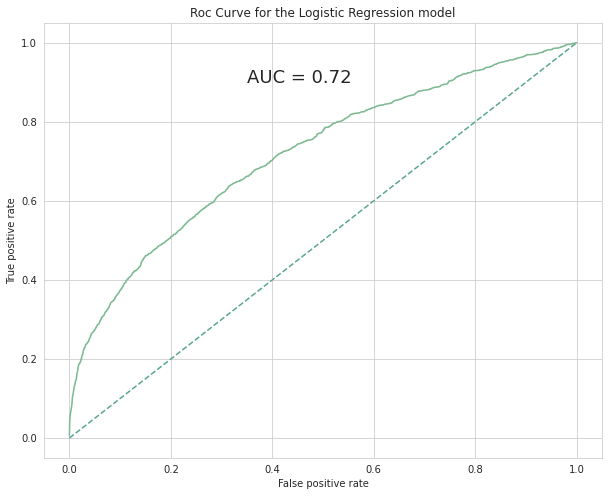

In [914]:
fpr_logreg, tpr_logreg, threshhols = roc_curve(y_test, y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(10, 8))
plt.title("Roc Curve for the Logistic Regression model")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.text(0.35, 0.9, f'AUC = {auc:.2f}', fontsize = 18)
ax = sns.lineplot(x=fpr_logreg, y=tpr_logreg)
sns.lineplot(x=[0, 1], y=[0, 1])
ax.lines[1].set_linestyle("--")
plt.show()

O modelo tem uma performance 44% melhor do que um modelo que define resultados aleatoriamente (AUC = 0.5)

**Buscando um *Optimal Threshold***

Esse processo tenta balancear uma regressão com uma quantidade muito diferente de classes

In [915]:
gmeans = np.sqrt(tpr_logreg * (1-fpr_logreg))
opt_thres_index = np.argmax(gmeans)
opt_threshold = threshhols[opt_thres_index]

In [916]:
y_pred2 = [1 if prob > opt_threshold else 0 for prob in y_pred_probs]

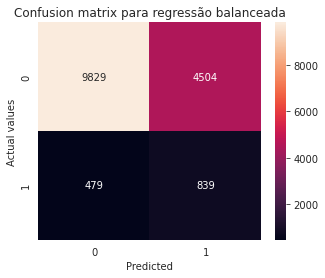

In [917]:
conf_matrix2 = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d')
plt.title('Confusion matrix para regressão balanceada')
plt.xlabel('Predicted')
plt.ylabel('Actual values')
plt.show()

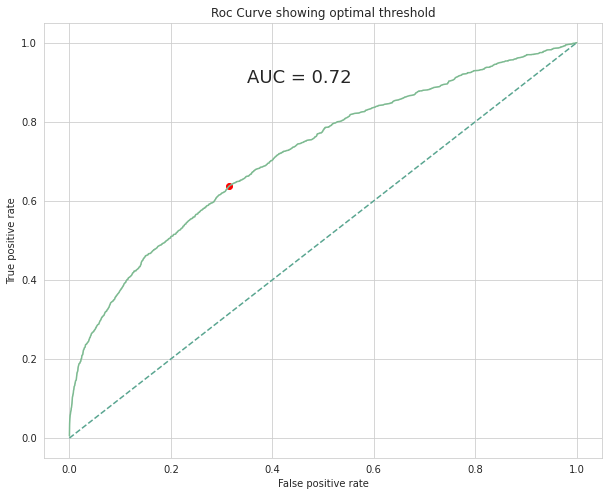

In [918]:
plt.figure(figsize=(10, 8))
plt.title("Roc Curve showing optimal threshold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.text(0.35, 0.9, f'AUC = {auc:.2f}', fontsize = 18)
ax = sns.lineplot(x=fpr_logreg, y=tpr_logreg)
sns.lineplot(x=[0, 1], y=[0, 1])
plt.scatter(fpr_logreg[opt_thres_index], tpr_logreg[opt_thres_index], marker='o', color='r')
ax.lines[1].set_linestyle("--")
plt.show()

In [919]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     14333
           1       0.16      0.64      0.25      1318

    accuracy                           0.68     15651
   macro avg       0.56      0.66      0.52     15651
weighted avg       0.89      0.68      0.75     15651



Com o uso de um _optimal threshold_, o recall foi aumentado, havendo um melhor _f1 score_. No entanto, a precissão para funcionários promovidos foi diminuída

#### **K Nearest Neighbors (KNN)**

In [920]:
X_knn = employees_train_dummy2.values

x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, stratify=y, test_size=0.3)

In [921]:
knn = KNeighborsClassifier()

n_space = range(5, 11)
params = {'n_neighbors': n_space}

knn_cv = GridSearchCV(knn, params, cv=5)

knn_cv.fit(x_train_knn, y_train_knn)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 11)})

In [922]:
knn_cv.best_params_

{'n_neighbors': 9}

In [923]:
knn_cv.best_score_

0.9293479333539203

In [924]:
cross_val_score(knn_cv.best_estimator_, X_knn, y, cv = kf)

array([0.9307073 , 0.93224075, 0.9297489 , 0.92725007, 0.93022141])

In [925]:
y_pred_knn = knn_cv.predict(x_test_knn)

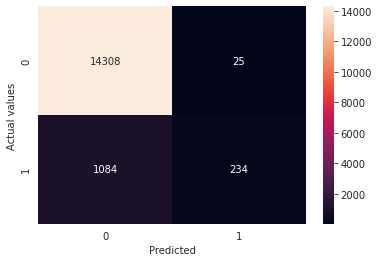

In [926]:
conf_matrix = confusion_matrix(y_test_knn, y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual values')
plt.show()

In [927]:
print(classification_report(y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14333
           1       0.90      0.18      0.30      1318

    accuracy                           0.93     15651
   macro avg       0.92      0.59      0.63     15651
weighted avg       0.93      0.93      0.91     15651



O recall é um pouco melhor para as pessoas promovidas, com alta precisão. Mas, mesmo assim, muitas pessoas que eram para ser promovidas continuam sendo previstas erroneamente

In [928]:
y_pred_probs_knn = knn_cv.predict_proba(x_test_knn)[:, 1]

In [929]:
auc = roc_auc_score(y_test_knn, y_pred_probs_knn)

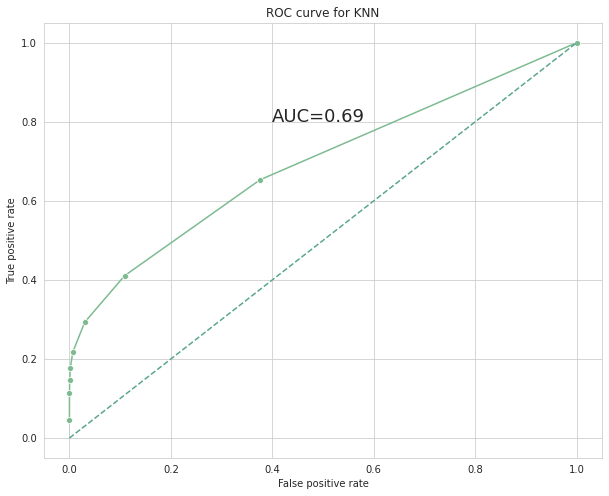

In [930]:
fpr_knn, tpr_knn, threshhols = roc_curve(y_test_knn, y_pred_probs_knn)
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x=fpr_knn, y=tpr_knn, marker='o')
plt.title('ROC curve for KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.4, 0.8, f'AUC={auc:.2f}', fontsize=18)
sns.lineplot(x=[0, 1], y=[0, 1])
ax.lines[1].set_linestyle('--')
plt.show()

#### **Gaussian Naive Bayes**

In [931]:
X_gnb = employees_train_dummy2.values

X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(X_gnb, y, stratify=y, test_size=0.3)

In [932]:
gaus_nb = GaussianNB()
gaus_nb.fit(X_train_gnb, y_train_gnb)

GaussianNB()

In [933]:
y_pred_gnb = gaus_nb.predict(X_test_gnb)

In [934]:
cross_val_score_gnb = cross_val_score(gaus_nb, X_gnb, y, scoring='accuracy')
cross_val_score_gnb

array([0.34732605, 0.46779758, 0.48773241, 0.47445605, 0.48499952])

In [935]:
cross_val_score_gnb.mean()

0.45246232423947974

In [936]:
accuracy_score(y_test_gnb, y_pred_gnb)

0.4823972909079292

A acurácia do modelo, tanto no _test set_ quanto na cross validaition é menor que 50%, o que indica que não vale a pena tentar melhorar o modleo com _hyperparameter tuning_. **Não vale a pena investigar as outras métricas**, pois o modelo já alcança uma menor acurácia

#### **Decision Tree Classifier**

In [937]:
X_dt = employees_train_dummy.values

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y, stratify=y, test_size=0.3)

In [938]:
dt = DecisionTreeClassifier(max_features='log2')
dt.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(max_features='log2')

In [939]:
y_pred_dt = dt.predict(X_test_dt)
y_pred_proba_dt = dt.predict_proba(X_test_dt)[:, 1]

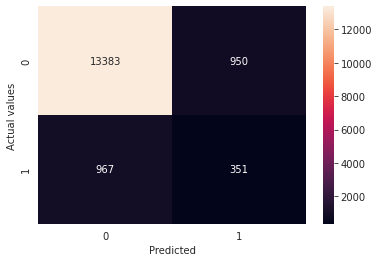

In [940]:
conf_dt = confusion_matrix(y_test_dt, y_pred_dt)
plt.figure()
sns.heatmap(conf_dt, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual values')
plt.show()

In [941]:
print(classification_report(y_test_dt, y_pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     14333
           1       0.27      0.27      0.27      1318

    accuracy                           0.88     15651
   macro avg       0.60      0.60      0.60     15651
weighted avg       0.88      0.88      0.88     15651



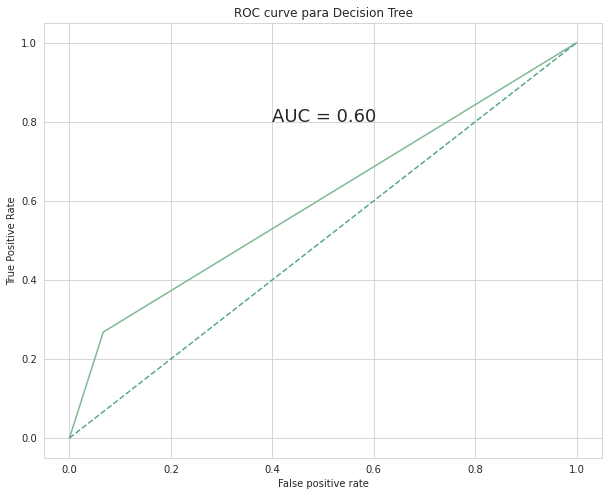

In [942]:
fpr, tpr, thresholds = roc_curve(y_test_dt, y_pred_proba_dt)
plt.figure(figsize=(10, 8))
plt.title('ROC curve para Decision Tree')
ax = sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0, 1], y=[0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
ax.lines[1].set_linestyle('--')
roc_auc = roc_auc_score(y_test_dt, y_pred_proba_dt)
plt.text(0.4, 0.8, f'AUC = {roc_auc:.2f}', fontsize=18)
plt.show()

Esse modelo conseguiu alcançar maior precisão e recall, tendo o meior _f1 score_ de todos até agora. No entatanto, a AUC ainda é maior para a regressão logística

#### **Random Forest**

Serão usados os mesmos _test_ e _training sets_ do modelo Decision Tree

In [943]:
rf = RandomForestClassifier(n_estimators=600)
rf.fit(X_train_dt, y_train_dt)

RandomForestClassifier(n_estimators=600)

In [944]:
y_pred_rf = rf.predict(X_test_dt)
y_pred_proba_rf = rf.predict_proba(X_test_dt)[:, 1]

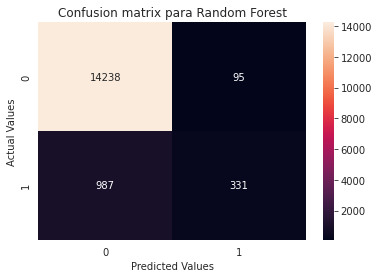

In [945]:
conf_rf = confusion_matrix(y_test_dt, y_pred_rf)
plt.figure()
plt.title('Confusion matrix para Random Forest')
sns.heatmap(conf_rf, annot=True, fmt='d')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [946]:
print(classification_report(y_test_dt, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     14333
           1       0.78      0.25      0.38      1318

    accuracy                           0.93     15651
   macro avg       0.86      0.62      0.67     15651
weighted avg       0.92      0.93      0.91     15651



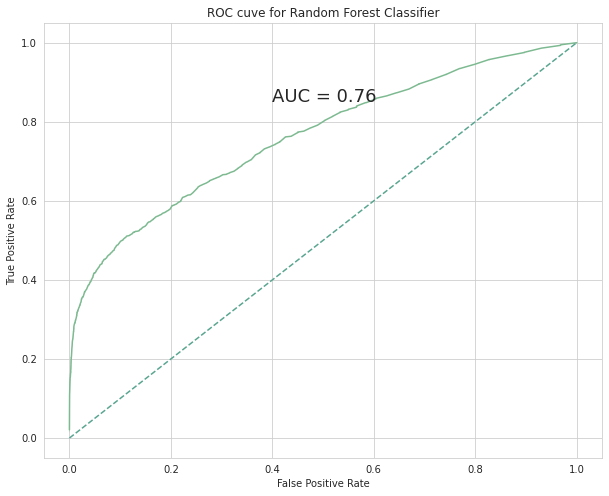

In [947]:
fpr, tpr, thresholds = roc_curve(y_test_dt, y_pred_proba_rf)
plt.figure(figsize=(10, 8))
ax = sns.lineplot(x=fpr, y=tpr)
plt.title('ROC cuve for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.lineplot(x=[0, 1], y=[0,1])
ax.lines[1].set_linestyle('--')
roc_auc = roc_auc_score(y_test_dt, y_pred_proba_rf)
plt.text(0.4, 0.85, f'AUC = {roc_auc:.2f}', fontsize=18)
plt.show()

Esse modelo aprenseta os maiores _AUC score_ e _f1_score_, sendo um grande canditado para melhor modelo, junto com a regressão logísitica

#### **Support Vector Classifier (SVM)**

In [948]:
X_svc = employees_train_dummy2.values

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, y, stratify=y, test_size=0.3, random_state=42) 

In [949]:
svc = SVC(probability=True, kernel='poly')
svc.fit(X_train_svc, y_train_svc)

SVC(kernel='poly', probability=True)

In [950]:
y_pred_svc = svc.predict(X_test_svc)
y_pred_proba_svc = svc.predict_proba(X_test_svc)[:, 1]

In [951]:
accuracy_score(y_test_svc, y_pred_svc)

0.915788128554086

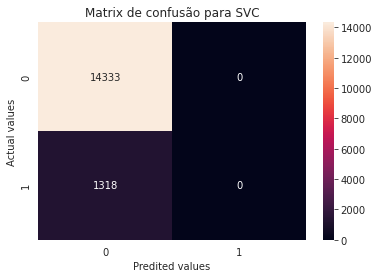

In [952]:
conf_svc = confusion_matrix(y_test_svc, y_pred_svc)
plt.figure()
plt.title('Matrix de confusão para SVC')
sns.heatmap(conf_svc, annot=True, fmt='d')
plt.ylabel('Actual values')
plt.xlabel('Predited values')
plt.show()

É possível perceber que o modelo não conseguiu identificar os promovidos devido ao grande desbalanceamento do dataset

#### **Adaptive Boosting**

In [953]:
dt_ada = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=dt_ada, n_estimators=500)
ada.fit(X_train_dt, y_train_dt)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500)

In [954]:
y_pred_ada = ada.predict(X_test_dt)
y_pred_proba_ada = ada.predict_proba(X_test_dt)[:, 1]

In [955]:
print(classification_report(y_test_dt, y_pred_ada))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14333
           1       0.59      0.22      0.32      1318

    accuracy                           0.92     15651
   macro avg       0.76      0.60      0.64     15651
weighted avg       0.90      0.92      0.90     15651



In [956]:
roc_auc_score(y_test_dt, y_pred_proba_ada)

0.7236239322501095

_Adaptive Boost_ não aumenta muito o f1-score em relação a uma _DecisionTree_ comum. No entando, a _ROC AUC_ é aumentada

#### **Gradient Boosting**

In [957]:
grad = GradientBoostingClassifier(n_estimators=900, max_features='log2', random_state=42)
grad.fit(X_train_dt, y_train_dt)

GradientBoostingClassifier(max_features='log2', n_estimators=900,
                           random_state=42)

In [958]:
y_pred_grad = grad.predict(X_test_dt)
y_pred_proba_grad = grad.predict_proba(X_test_dt)[:, 1]

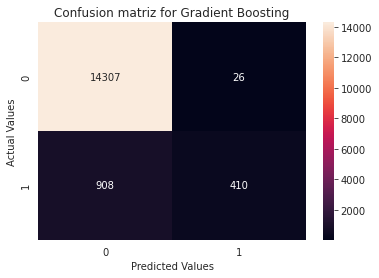

In [959]:
conf_grad = confusion_matrix(y_test_dt, y_pred_grad)
plt.figure()
plt.title('Confusion matriz for Gradient Boosting')
sns.heatmap(conf_grad, annot=True, fmt='d')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [960]:
print(classification_report(y_test_dt, y_pred_grad))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     14333
           1       0.94      0.31      0.47      1318

    accuracy                           0.94     15651
   macro avg       0.94      0.65      0.72     15651
weighted avg       0.94      0.94      0.93     15651



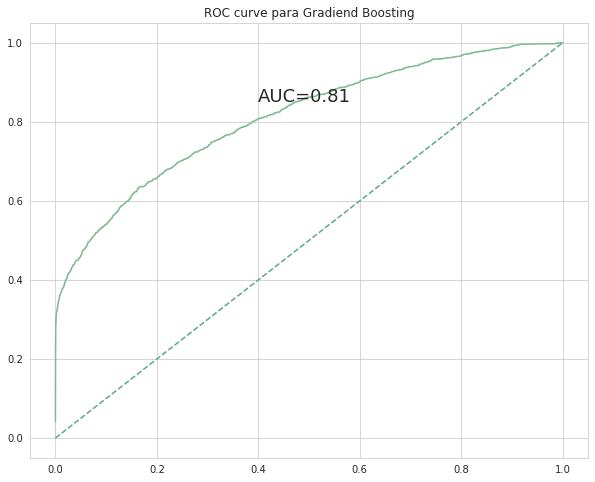

In [961]:
fpr, tpr, tresholds = roc_curve(y_test_dt, y_pred_proba_grad)
roc_auc_grad = roc_auc_score(y_test_dt, y_pred_proba_grad)
plt.figure(figsize=(10, 8))
plt.title('ROC curve para Gradiend Boosting')
ax = sns.lineplot(x=fpr, y=tpr)
sns.lineplot(x=[0,1], y=[0,1])
ax.lines[1].set_linestyle('--')
plt.text(0.4, 0.85, f'AUC={roc_auc_grad:.2f}', fontsize=18)
plt.show()

#### **Conclusão**

Analisando as métricas de todos os modelos, é mais importante analisar a área sob o gráfico ROC do que a acurácia, já que o dataset é desbalanceado, ou seja, há muito menos funcionários promovidos do que não promovidos.

Dessa forma, os dois melhores modelos são _Random Forest_ e _Logistic Regression_, sendo que ambos têm AUCs (_areas under the curve_) praticamente iguais.

O modelo com o maior _f1 socore_ e com a maior área sob a curva ROC (`ROC AUC`) é o modelo de **Gradient Boosting**

### Previsão final

In [962]:
test_employees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 8724 to 5973
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   department            23481 non-null  object  
 1   region                23481 non-null  object  
 2   education             23481 non-null  object  
 3   gender                23481 non-null  object  
 4   recruitment_channel   23481 non-null  object  
 5   no_of_trainings       23481 non-null  float64 
 6   age                   23481 non-null  int64   
 7   previous_year_rating  23481 non-null  float64 
 8   length_of_service     23481 non-null  int64   
 9   awards_won?           23481 non-null  category
 10  avg_training_score    23481 non-null  int64   
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [963]:
test_employees_dummy = pd.get_dummies(test_employees, drop_first=True)

In [964]:
final_predictions = grad.predict(test_employees_dummy.values)

In [965]:
final_employees = test_employees
final_employees['is_promoted'] = final_predictions

In [966]:
final_employees['is_promoted']

employee_id
8724     0
74430    0
72255    0
38562    0
64486    0
        ..
53478    0
25600    0
45409    0
1186     0
5973     1
Name: is_promoted, Length: 23481, dtype: int64

## **Resultados**

O modelo alcançado apresenta uma alta precisão, o que garante sua confiabilidade.

No entanto, devido ao mais baixo _recall_, ainda é necessária uma análise individual dos funcionários para a promoção, já que muitas pessoa com grande potencial de promoção podem estar sendo classificadas incorretamente pelo modelo.